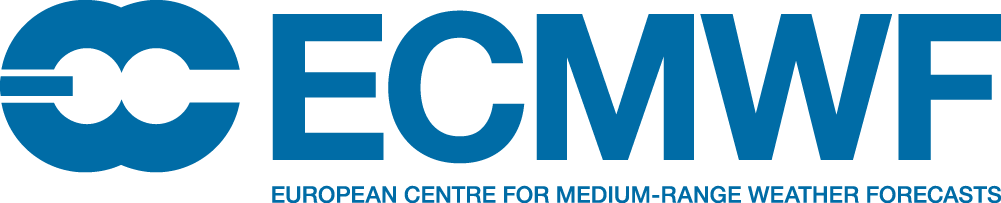
# CCSDS compression in ECMWF Real-time open data 

In June 2023 ECMWF will update its IFS forecast model to 48r1 version. This is a major model change with several updates which are described [here](https://confluence.ecmwf.int/display/FCST/Implementation+of+IFS+Cycle+48r1).  

With 48r1 all **gridded GRIB2 "raw"** data will use the [new CCSDS packing type](https://codes.ecmwf.int/grib/format/grib2/templates/5/42/). Since all data in [Open data dataset](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts) are GRIB2, this means that all open data will have the new packing. More about the CCSDS packing you can read in [ecCodes FAQ](https://confluence.ecmwf.int/pages/viewpage.action?pageId=146658047)

In this notebook you will see how to download test data from 48r1 cycle and inspect the data.  
With thelatest versions of ECMWF libraries ecCodes and metview, and community Python tools such as cfgrib and xarray users should see **no difference in their work** using ECMWF real-time open data.

## Libraries to work with GRIB data

There are many tools to work with GRIB data. Here you will find how to inspect new ECMWF open data using [**Metview**](https://metview.readthedocs.io/en/latest/index.html) and [**xarray**](https://docs.xarray.dev/en/stable/).  
To download open data we will use [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Python library.  

We will also use [**matplotlib**](https://matplotlib.org/) and [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/index.html) to plot the data.

In [1]:
from ecmwf.opendata import Client

import metview as mv

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

## Download data

To download current operational open forecast data, set source to '**ecmwf**', and for test (esuite) data, set the source to '**ecmwf-esuites**'

In [2]:
client_o = Client("ecmwf", beta=True)
client_e = Client("ecmwf-esuites", beta=True)

Let's download something simple such as temperature and geopotential height at 500 and 850 hPa. 

In [3]:
parameters = ['gh', 't']
filename_osuite = 'open_data_operational.grib'
filename_esuite = 'open_data_esuite.grib'

Test forecast is usually available a bit late, so just in case you are running this early in the morning, let's set the date parameter to yesterday.  
First we download operational data:

In [4]:
client_o.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[500,850],
    param=parameters,
    target=filename_osuite
)

20230328000000-12h-oper-fc.grib2:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

And then the esuite test data.  
Note that everything is the same except the file name and client that we used.

In [5]:
client_e.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[500,850],
    param=parameters,
    target=filename_esuite
)

20230328000000-12h-oper-fc.grib2:   0%|          | 0.00/909k [00:00<?, ?B/s]

Let's check what we've downloaded.  
Note the difference in size between operational and esuite data. 

In [6]:
!ls -lrt open_data*.grib

-rw-r--r--  1 mamv  staff  2436184 30 Mar 14:04 open_data_operational.grib
-rw-r--r--  1 mamv  staff   931176 30 Mar 14:04 open_data_esuite.grib


## Explore the data using Metview
We can now see what is in the downloaded files.

In [7]:
data_osuite = mv.read(filename_osuite)
data_esuite = mv.read(filename_esuite)

Using Metview's **describe()** function we can see that we indeed have the same parameters on the same levels for the same date and step.   
The only difference we see here is **experimentVersionNumber**. Typically, **001** represents the **operational version**, and **0078 next candidate for the operational version (esuite)**.

In [8]:
data_osuite.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,"500,850",20230328,0,12,None,156,od,oper,fc,0001
t,isobaricInhPa,"500,850",20230328,0,12,None,130,od,oper,fc,0001


In [9]:
data_esuite.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,"500,850",20230328,0,12,None,156,od,oper,fc,0078
t,isobaricInhPa,"500,850",20230328,0,12,None,130,od,oper,fc,0078


We can also use Metview to check other GRIB metadata.  For this **grib_get()** function is very useful.  

Lets check:
 - **editionNumber** - to make sure our data is GRIB2
 - **Ni and Nj** - number of points in x and y direction
 - **packingType** - we expect this to be the only different key between our two GRIB files  
 
 The results are given for each field in our fieldsets. We can see that indeed we have downloaded data in GRIB2 format and operational data has **grid_simple** packing, while new test data has **grid_ccsds** packing.

In [10]:
mv.grib_get(data_osuite, ['shortName', 'editionNumber', 'Ni', 'Nj', 'gridType', 'packingType'])

[['gh', '2', '900', '451', 'regular_ll', 'grid_simple'],
 ['gh', '2', '900', '451', 'regular_ll', 'grid_simple'],
 ['t', '2', '900', '451', 'regular_ll', 'grid_simple'],
 ['t', '2', '900', '451', 'regular_ll', 'grid_simple']]

In [11]:
mv.grib_get(data_esuite, ['shortName', 'editionNumber', 'Ni', 'Nj', 'gridType', 'packingType'])

[['gh', '2', '900', '451', 'regular_ll', 'grid_ccsds'],
 ['gh', '2', '900', '451', 'regular_ll', 'grid_ccsds'],
 ['t', '2', '900', '451', 'regular_ll', 'grid_ccsds'],
 ['t', '2', '900', '451', 'regular_ll', 'grid_ccsds']]

## Convert to simple pakcing

Converting between packings is simple using Metview as well. For this **grib_set()** function is handy.

In [12]:
data_esuite_to_simple = mv.grib_set(data_esuite, ["packingType", "grid_simple"], repack=True)

And to make sure it did what we wanted, let's check using grib_get() again.

In [13]:
mv.grib_get(data_esuite_to_simple, ['packingType'])

[['grid_simple'], ['grid_simple'], ['grid_simple'], ['grid_simple']]

In [14]:
print(mv.minvalue(data_esuite_to_simple[0]), mv.minvalue(data_esuite[0]))

4820.99609375 4820.99609375


## Plotting
We can plot the data with simple and ccsds packing to make sure it all looks the same. We will use the same style.

In [15]:
contours = mv.mcont(contour_automatic_setting='ecmwf', legend='on')

In [16]:
t850_esuite = data_esuite.select(shortName='t', level=850)
gh500_esuite = data_esuite.select(shortName='gh', level=500)/10

In [17]:
mv.plot(t850_esuite,contours,gh500_esuite,contours)

Image(value=b'', layout="Layout(visibility='hidden')")

Label(value='Generating plots....')

In [18]:
t850_esuite_simple = data_esuite_to_simple.select(shortName='t', level=850)
gh500_esuite_simple = data_esuite_to_simple.select(shortName='gh', level=500)/10

In [19]:
mv.plot(t850_esuite_simple,contours,gh500_esuite_simple,contours)

Image(value=b'', layout="Layout(visibility='hidden')")

Label(value='Generating plots....')

## Exploring the data using xarray and cfgrib

Using the latest version of cfgrib as the grib engine for xarray will ensure that ccsds compressed data works in xarray.  
Here we explore same two files using xarray.

In [23]:
ds_esuite = xr.open_dataset(filename_esuite, engine='cfgrib')
ds_esuite

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 2, latitude: 451, longitude: 900)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 850.0 500.0
  * latitude       (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude      (longitude) float64 -180.0 -179.6 -179.2 ... 179.2 179.6
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-03-30T14:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [24]:
ds_osuite = xr.open_dataset(filename_osuite, engine='cfgrib')
ds_osuite

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 2, latitude: 451, longitude: 900)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 850.0 500.0
  * latitude       (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude      (longitude) float64 -180.0 -179.6 -179.2 ... 179.2 179.6
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-03-30T14:05 GRIB to CDM+CF via cfgrib-0.9.1...

And finally we can use matplotlib and cartopy to plot both operational and test data.

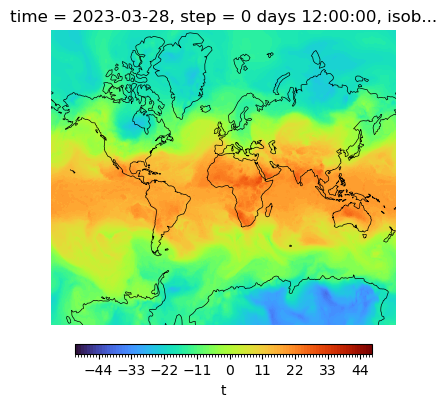

In [25]:
my_data_osuite = ds_osuite.t.sel(isobaricInhPa=850)-273.15
projection = ccrs.Mercator()
ax = plt.axes(projection=projection, frameon=False)
ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=0.5)

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':30}
my_data_osuite.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, levels=101, cmap='turbo', vmin=-52, vmax=48)


plt.show()

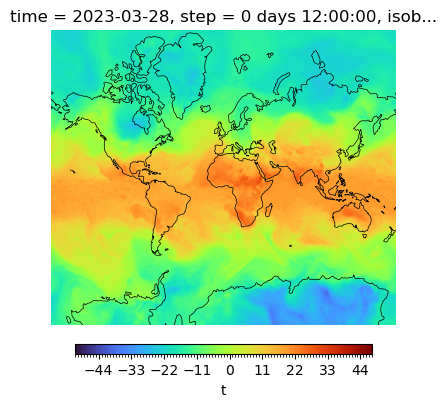

In [26]:
my_data_esuite = ds_esuite.t.sel(isobaricInhPa=850)-273.15
projection = ccrs.Mercator()
ax = plt.axes(projection=projection, frameon=False)
ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=0.5)

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':30}
my_data_esuite.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, levels=101, cmap='turbo', vmin=-52, vmax=48)


plt.show()